In [11]:
!pip install pulp

     |████████████████████████████████| 14.2 MB 212 kB/s eta 0:00:01


In [ ]:
import pandas as pd
import numpy as np
from pulp import *

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
menu = pd.read_csv('menu.csv')
menu.head()

,Category,Item,Serving Size,Calories,Calories from Fat,Total Fat,Total Fat (% Daily Value),Saturated Fat,Saturated Fat (% Daily Value),Trans Fat,...,Carbohydrates,Carbohydrates (% Daily Value),Dietary Fiber,Dietary Fiber (% Daily Value),Sugars,Protein,Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value)
0,Breakfast,Egg McMuffin,4.8 oz (136 g),300,120,13.0,20,5.0,25,0.0,...,31,10,4,17,3,17,10,0,25,15
1,Breakfast,Egg White Delight,4.8 oz (135 g),250,70,8.0,12,3.0,15,0.0,...,30,10,4,17,3,18,6,0,25,8
2,Breakfast,Sausage McMuffin,3.9 oz (111 g),370,200,23.0,35,8.0,42,0.0,...,29,10,4,17,2,14,8,0,25,10
3,Breakfast,Sausage McMuffin with Egg,5.7 oz (161 g),450,250,28.0,43,10.0,52,0.0,...,30,10,4,17,2,21,15,0,30,15
4,Breakfast,Sausage McMuffin with Egg Whites,5.7 oz (161 g),400,210,23.0,35,8.0,42,0.0,...,30,10,4,17,2,21,6,0,25,10


## General Information & Missing Values

In [13]:
menu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Category                       260 non-null    object 
 1   Item                           260 non-null    object 
 2   Serving Size                   260 non-null    object 
 3   Calories                       260 non-null    int64  
 4   Calories from Fat              260 non-null    int64  
 5   Total Fat                      260 non-null    float64
 6   Total Fat (% Daily Value)      260 non-null    int64  
 7   Saturated Fat                  260 non-null    float64
 8   Saturated Fat (% Daily Value)  260 non-null    int64  
 9   Trans Fat                      260 non-null    float64
 10  Cholesterol                    260 non-null    int64  
 11  Cholesterol (% Daily Value)    260 non-null    int64  
 12  Sodium                         260 non-null    int

In [14]:
menu.isna().sum()

Category                         0
Item                             0
Serving Size                     0
Calories                         0
Calories from Fat                0
Total Fat                        0
Total Fat (% Daily Value)        0
Saturated Fat                    0
Saturated Fat (% Daily Value)    0
Trans Fat                        0
Cholesterol                      0
Cholesterol (% Daily Value)      0
Sodium                           0
Sodium (% Daily Value)           0
Carbohydrates                    0
Carbohydrates (% Daily Value)    0
Dietary Fiber                    0
Dietary Fiber (% Daily Value)    0
Sugars                           0
Protein                          0
Vitamin A (% Daily Value)        0
Vitamin C (% Daily Value)        0
Calcium (% Daily Value)          0
Iron (% Daily Value)             0
dtype: int64

In [10]:
menu.duplicated().sum()

0

In [15]:
menu.dtypes

Category                          object
Item                              object
Serving Size                      object
Calories                           int64
Calories from Fat                  int64
Total Fat                        float64
Total Fat (% Daily Value)          int64
Saturated Fat                    float64
Saturated Fat (% Daily Value)      int64
Trans Fat                        float64
Cholesterol                        int64
Cholesterol (% Daily Value)        int64
Sodium                             int64
Sodium (% Daily Value)             int64
Carbohydrates                      int64
Carbohydrates (% Daily Value)      int64
Dietary Fiber                      int64
Dietary Fiber (% Daily Value)      int64
Sugars                             int64
Protein                            int64
Vitamin A (% Daily Value)          int64
Vitamin C (% Daily Value)          int64
Calcium (% Daily Value)            int64
Iron (% Daily Value)               int64
dtype: object

#### Dari hasil tersebut, kita dapat menyimpulkan bahwa tidak ada nilai null dalam dataset dan semua tipe data kolom benar, kecuali kolom Serving Size karena seharusnya bernilai int64, bukan tipe data object. Sebagian besar zat gizi memiliki kolom persentase kebutuhan harian. Nanti kita tambahkan kolom Gula, Protein, dan Kalori dalam persentase kebutuhan harian. Jika kita membaca bagaimana semua data ditulis dalam Ukuran Penayangan. ada beberapa unit berat/volume untuk menggambarkan menu. Yaitu Ons (oz), Cairan Ons (fl oz), Gram (g) dan Mililiter (ml). Sebagian besar data menggunakan unit ons atau gram untuk makanan dan oz cairan untuk minuman, tetapi beberapa data seperti produk Low Fat Milk Jug 1% dan Fat-Free Chocolate Milk Jug menggunakan unit mililiter. Jadi kita akan mengubah semua satuan ke satuan gram, dan untuk data yang tidak menyediakan satuan massa (seperti ons cairan atau mililiter), kita akan menggunakan massa jenis susu (Hanya item susu yang tidak memiliki satuan massa) untuk mililiter dan daripada untuk cairan sekali kita akan menggunakan kerapatan air murni.

In [17]:
serving_size_conv = []
for i in menu['Serving Size']:
    if '(' in i and 'g)' in i:
        serving_size_conv.append(float(i[i.find('(')+1:-3])) 
    elif 'fl oz' in i:
        serving_size_conv.append(float(i[0:i.find(' ')])*29.5735) ## kira-kira 1 fl oz = 29.5735 g
    elif '(' and 'ml)':
        serving_size_conv.append(float(i[i.find('(')+1:-4])*1.04) ## kira-kira 1 ml = 1.04g

menu['Serving Size']= pd.DataFrame(serving_size_conv).astype('float')
menu.head(2)

,Category,Item,Serving Size,Calories,Calories from Fat,Total Fat,Total Fat (% Daily Value),Saturated Fat,Saturated Fat (% Daily Value),Trans Fat,...,Carbohydrates,Carbohydrates (% Daily Value),Dietary Fiber,Dietary Fiber (% Daily Value),Sugars,Protein,Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value)
0,Breakfast,Egg McMuffin,136.0,300,120,13.0,20,5.0,25,0.0,...,31,10,4,17,3,17,10,0,25,15
1,Breakfast,Egg White Delight,135.0,250,70,8.0,12,3.0,15,0.0,...,30,10,4,17,3,18,6,0,25,8


#### Setelah kolom Serving Size dinormalkan, mari tambahkan kolom Gula, Protein, dan Kalori dalam satuan persentase daily needs.

In [18]:
menu['Calories (% Daily Value)'] = menu['Calories']*100/2500 
menu['Sugars (% Daily Value)'] = menu['Sugars']*100/30
menu['Protein (% Daily Value)'] = menu['Protein']*100/50
menu.head(2)


,Category,Item,Serving Size,Calories,Calories from Fat,Total Fat,Total Fat (% Daily Value),Saturated Fat,Saturated Fat (% Daily Value),Trans Fat,...,Dietary Fiber (% Daily Value),Sugars,Protein,Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value),Calories (% Daily Value),Sugars (% Daily Value),Protein (% Daily Value)
0,Breakfast,Egg McMuffin,136.0,300,120,13.0,20,5.0,25,0.0,...,17,3,17,10,0,25,15,12.0,10.0,34.0
1,Breakfast,Egg White Delight,135.0,250,70,8.0,12,3.0,15,0.0,...,17,3,18,6,0,25,8,10.0,10.0,36.0


##### setelah dataset diCheck dan dibersihkan/Cleaning. sekarang dataset siap digunakan dan kita bisa mulai menyelami dataset kita

## Data Exploration

In [20]:
menu.describe()

,Serving Size,Calories,Calories from Fat,Total Fat,Total Fat (% Daily Value),Saturated Fat,Saturated Fat (% Daily Value),Trans Fat,Cholesterol,Cholesterol (% Daily Value),...,Dietary Fiber (% Daily Value),Sugars,Protein,Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value),Calories (% Daily Value),Sugars (% Daily Value),Protein (% Daily Value)
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,...,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,376.234264,368.269231,127.096154,14.165385,21.815385,6.007692,29.965385,0.203846,54.942308,18.392308,...,6.530769,29.423077,13.338462,13.426923,8.534615,20.973077,7.734615,14.730769,98.076923,26.676923
std,208.960847,240.269886,127.875914,14.205998,21.885199,5.321873,26.639209,0.429133,87.269257,29.091653,...,6.307057,28.679797,11.426146,24.366381,26.345542,17.019953,8.723263,9.610795,95.599322,22.852292
min,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,199.250000,210.000000,20.000000,2.375000,3.750000,1.000000,4.750000,0.000000,5.000000,2.000000,...,0.000000,5.750000,4.000000,2.000000,0.000000,6.000000,0.000000,8.400000,19.166667,8.000000
50%,354.882000,340.000000,100.000000,11.000000,17.000000,5.000000,24.000000,0.000000,35.000000,11.000000,...,5.000000,17.500000,12.000000,8.000000,0.000000,20.000000,4.000000,13.600000,58.333333,24.000000
75%,473.176000,500.000000,200.000000,22.250000,35.000000,10.000000,48.000000,0.000000,65.000000,21.250000,...,10.000000,48.000000,19.000000,15.000000,4.000000,30.000000,15.000000,20.000000,160.000000,38.000000
max,946.352000,1880.000000,1060.000000,118.000000,182.000000,20.000000,102.000000,2.500000,575.000000,192.000000,...,28.000000,128.000000,87.000000,170.000000,240.000000,70.000000,40.000000,75.200000,426.666667,174.000000


### Rata-rata Calories dalam menu McDonald's adalah 368,27 kal. Mari kita lihat berapa banyak makanan dan minuman di menu dan dari mana kalori itu berasal.

In [22]:
by_category = pd.DataFrame({'Category':menu['Category'].value_counts().index.tolist(),
                            'Count':menu['Category'].value_counts().tolist(),
                            'Calories (Sum)':menu[['Category','Calories']].groupby('Category').sum()['Calories'],
                            'Calories (Mean)':menu[['Category','Calories']].groupby('Category').mean()['Calories']})
by_category.reset_index(drop = True)

,Category,Count,Calories (Sum),Calories (Mean)
0,Coffee & Tea,95,7410,494.000000
1,Breakfast,42,3070,113.703704
2,Smoothies & Shakes,28,22120,526.666667
3,Chicken & Fish,27,14930,552.962963
4,Beverages,27,26970,283.894737
5,Beef & Pork,15,1555,222.142857
6,Snacks & Sides,13,1620,270.000000
7,Desserts,7,14880,531.428571
8,Salads,6,3195,245.769231


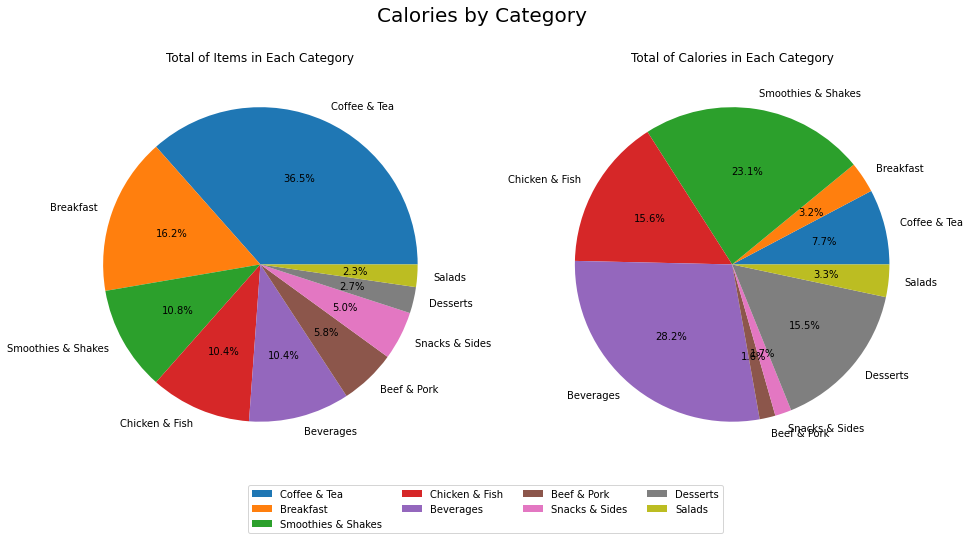

In [23]:
fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(15.5, 7.5)
ax1.set_title("Total of Items in Each Category")
ax1.pie(by_category['Count'],labels =by_category['Category'],autopct = '%1.1f%%')

ax2.set_title("Total of Calories in Each Category")
ax2.pie(by_category['Calories (Sum)'],labels =by_category['Category'],autopct = '%1.1f%%')

fig.suptitle('Calories by Category',fontsize = 20)
fig.legend(by_category['Category'],ncol=4,loc=8)

#### Dari gambar tersebut, menu terbanyak adalah Coffee & Tea (36,5%) dan kalori terbanyak berasal dari Chicken & Fish (28,2%). Jika kita melihat makanan penutup, dengan hanya 7 item (2,7%) dalam menu (Item kedua dalam menu), itu mendapat 15,5% kalori (Empat kalori terbanyak dalam menu).

#### Mari kita lihat bagaimana korelasi antara nutrisi dengan Heatmap plot

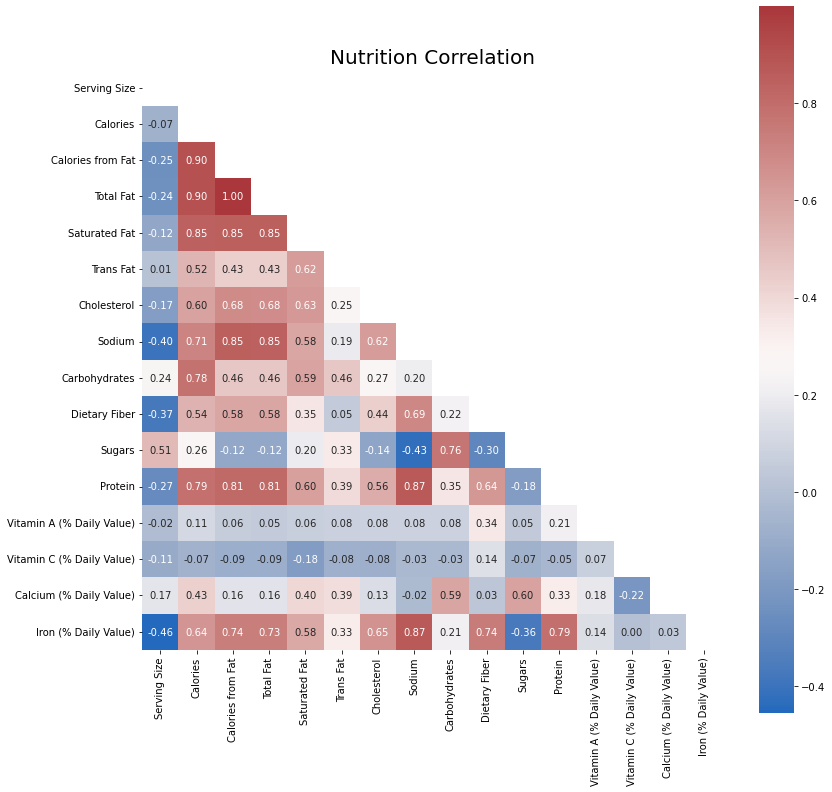

In [25]:
nutrition = ['Serving Size',
 'Calories',
 'Calories from Fat',
 'Total Fat',
 'Saturated Fat',
 'Trans Fat',
 'Cholesterol',
 'Sodium',
 'Carbohydrates',
 'Dietary Fiber',
 'Sugars',
 'Protein',
 'Vitamin A (% Daily Value)',
 'Vitamin C (% Daily Value)',
 'Calcium (% Daily Value)',
 'Iron (% Daily Value)']

corr = menu[nutrition].corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig = plt.figure(figsize = (13,13))

ax = sns.heatmap(corr,
                 mask = mask,
                 square =True,
                 cmap="vlag",
                 annot=True,
                 fmt="1.2f"
                )
ax.set_title("Nutrition Correlation",fontsize = 20);

### Dari gambar tersebut, kita dapat menyimpulkan bahwaFat memiliki korelasi tertinggi dengan Calories. Ini berarti lebih banyak Fat dalam menu dapat berarti lebih banyak Calories juga. diikuti oleh Protein di tempat kedua (0,79) dan Karbohidrat di tempat ketiga (0,78). Selain korelasi dengan kalori, ada skor korelasi yang tinggi pada fitur lain, misalnya korelasi antara Sodium dan Iron (0,87), dan Sodium antara Protein (0,87).

### Setelah mengetahui beberapa informasi menarik, kita akan tahu apakah memesan Grilled Chicken bukan Crispy Chicken meningkatkan nilai gizi sandwich?

In [27]:
crispy_vs_no = menu[menu['Item'].str.contains('Sandwich')].reset_index(drop=True)

crispy = crispy_vs_no[crispy_vs_no['Item'].str.contains('Crispy')].reset_index(drop=True)
grilled = crispy_vs_no[crispy_vs_no['Item'].str.contains('Grilled')].reset_index(drop=True)

label = grilled[grilled['Item'].str.contains('Grilled')]['Item'].replace('Grilled','',regex = True).tolist()

crispy.drop(['Category','Item','Serving Size'], axis=1,inplace = True)
grilled.drop(['Category','Item','Serving Size'], axis=1,inplace = True)

crispy_vs_no.head(5)

,Category,Item,Serving Size,Calories,Calories from Fat,Total Fat,Total Fat (% Daily Value),Saturated Fat,Saturated Fat (% Daily Value),Trans Fat,...,Dietary Fiber (% Daily Value),Sugars,Protein,Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value),Calories (% Daily Value),Sugars (% Daily Value),Protein (% Daily Value)
0,Chicken & Fish,Premium Crispy Chicken Classic Sandwich,213.0,510,200,22.0,33,3.5,18,0.0,...,13,10,24,4,6,15,20,20.4,33.333333,48.0
1,Chicken & Fish,Premium Grilled Chicken Classic Sandwich,200.0,350,80,9.0,13,2.0,9,0.0,...,13,8,28,4,8,15,20,14.0,26.666667,56.0
2,Chicken & Fish,Premium Crispy Chicken Club Sandwich,249.0,670,300,33.0,51,9.0,44,0.0,...,14,11,36,8,20,30,20,26.8,36.666667,72.0
3,Chicken & Fish,Premium Grilled Chicken Club Sandwich,235.0,510,180,20.0,31,7.0,36,0.0,...,13,9,40,8,20,30,20,20.4,30.000000,80.0
4,Chicken & Fish,Premium Crispy Chicken Ranch BLT Sandwich,230.0,610,250,28.0,43,6.0,31,0.0,...,13,11,32,4,20,15,20,24.4,36.666667,64.0


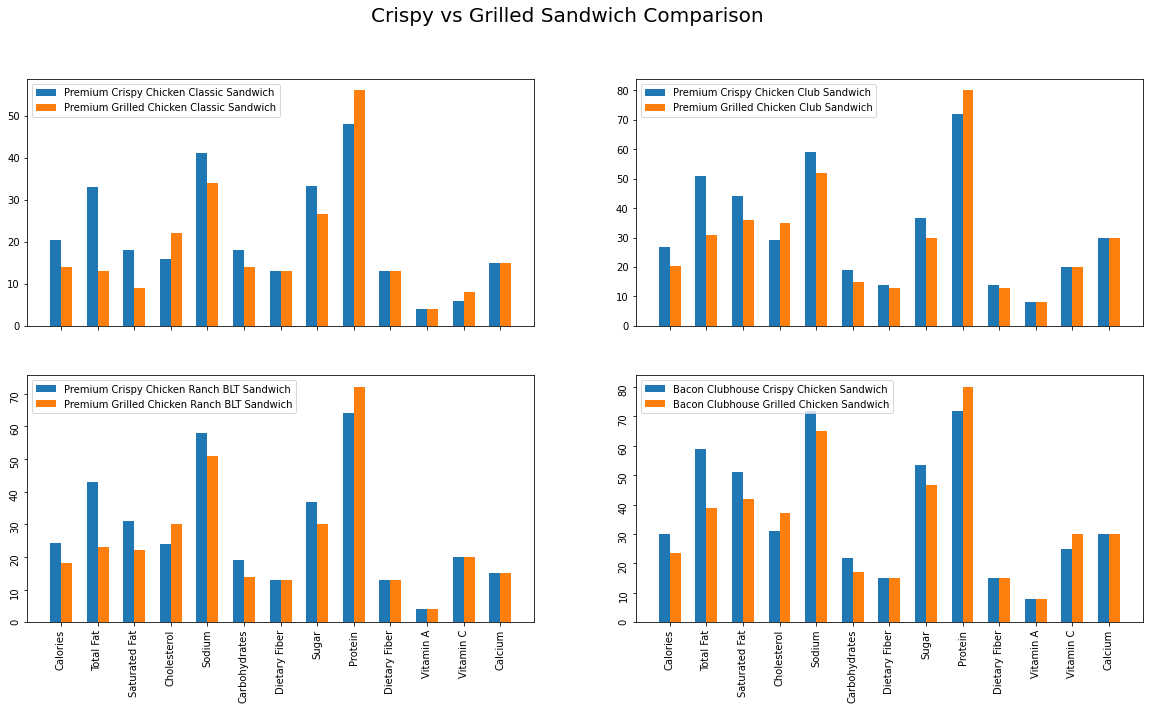

In [28]:
def comparison_plot(dataframe,plot_title,row,column,last_blank = False):
    label = ['Calories (% Daily Value)','Total Fat (% Daily Value)','Saturated Fat (% Daily Value)'
             ,'Cholesterol (% Daily Value)','Sodium (% Daily Value)','Carbohydrates (% Daily Value)'
             ,'Dietary Fiber (% Daily Value)','Sugars (% Daily Value)','Protein (% Daily Value)'
             ,'Dietary Fiber (% Daily Value)','Vitamin A (% Daily Value)','Vitamin C (% Daily Value)'
             ,'Calcium (% Daily Value)']

    label_tick = ['Calories','Total Fat','Saturated Fat','Cholesterol','Sodium','Carbohydrates'
             ,'Dietary Fiber','Sugar','Protein','Dietary Fiber','Vitamin A','Vitamin C','Calcium']
    
    n = len(label)
    ind = np.arange(n)

    width = 0.3
    fig,axs = plt.subplots(row,column)
    
    if last_blank:
        axs[-1, -1].axis('off')
    
    fig.set_figheight(10)
    fig.set_figwidth(20)

    index = 0
    for ax in axs:
        for x in ax:
            if last_blank and index == (row*column*2)-2:
                continue
            x.bar(ind - width/2,dataframe.iloc[index][label].tolist(),width,label = dataframe.iloc[index]['Item'])
            x.bar(ind + width/2,dataframe.iloc[index+1][label].tolist(),width,label =dataframe.iloc[index+1]['Item'])
            if index == 4 or index == 6:
                x.set_xticks(ind)
                x.set_xticklabels(label_tick)
                x.tick_params(labelrotation=90)
            else:
                x.set_xticks(ind)
                x.set_xticklabels([""]*len(label_tick))
            x.legend()
            index +=2
    fig.suptitle(plot_title,fontsize = 20)
comparison_plot(crispy_vs_no,'Crispy vs Grilled Sandwich Comparison',2,2)

### Dari visualisasi diatas, sebagian besar Crispy sandwich memiliki lebih banyak nutrisi daripada Grilled Sandwich. Namun pada Grilled Sandwich lebih banyak mengandung kolesterol, protein dan vitamin c dibandingkan dengan Crispy sandwich.

### Mari kita lihat apakah memesan White Egg daripada Whole Egg dapat mempengaruhi nutrisi?

In [34]:
egg =  menu[menu['Item'].str.contains('with')&menu['Item'].str.contains('Egg') & ~menu['Item'].str.contains('White')].reset_index(drop=True)
egg_vs_white = pd.DataFrame(columns = menu.columns)
for i in egg['Item']:
    regex = "^"
    
    for j in i.split(" "):
        regex += "(?=.*"+j+")"
    regex+= ".*$"
    a = menu[menu['Item'].str.contains(regex)]
    egg_vs_white = egg_vs_white.append(a,ignore_index = True)

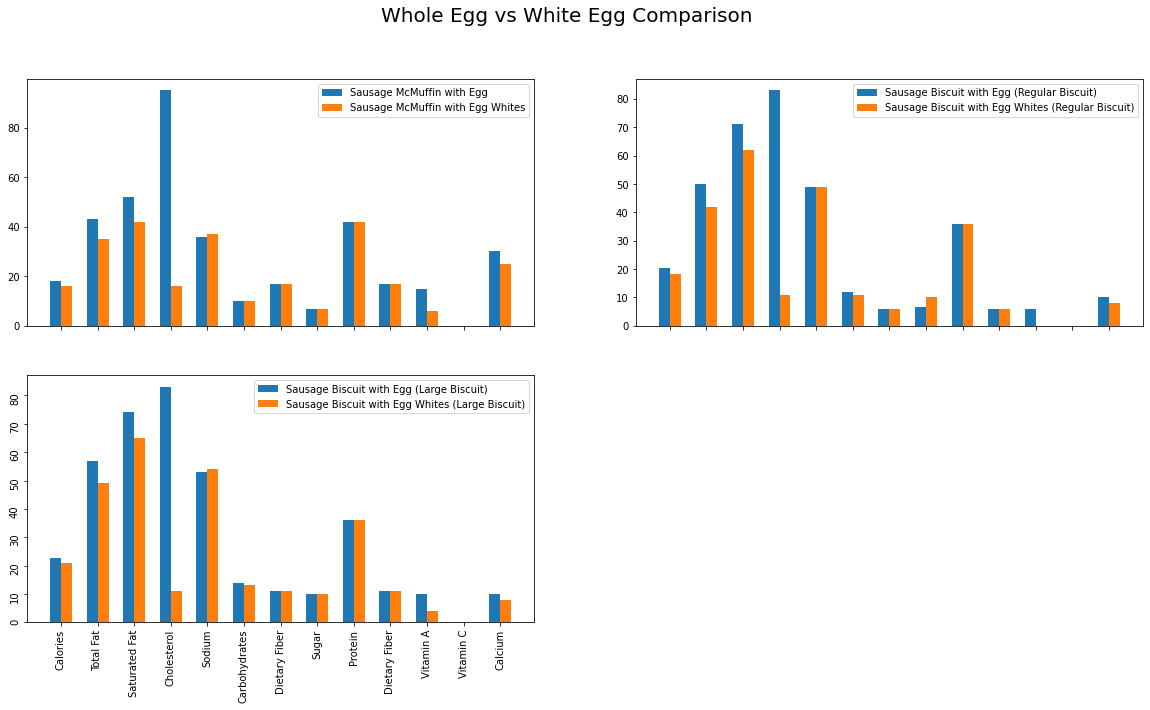

In [35]:
comparison_plot(egg_vs_white,"Whole Egg vs White Egg Comparison",2,2,last_blank = True)


### Dari gambar tersebut, Item dengan Whole egg memiliki lebih banyak nutrisi daripada white egg. Tapi, kuning telur mengandung banyak kolesterol. Hal ini terlihat dari perbedaan yang signifikan antara kolesterol pada whole egg dan kolesterol pada white egg saja. Bedanya bisa sampai tujuh kali.